# ROC与AUC

ROC：Receiver Operating Characteristic


首先，需要了解TP、FP、TN、FN等基本概念。

对于二分类问题，可以将样例根据其真实类别和学习器预测类别划分成真正例（TP，True Positive）、假正例（FP，False Positive）、真反例（TN，True Negative）、假反例（FN，False Negative）四种情形。

<table>
<tbody>
   <tr><td rowspan="2" style="text-align:center">真实情况</td><td colspan="2" style="text-align:center">预测结果</td></tr>
   <tr><td style="text-align:center">正例</td><td style="text-align:center">反例</td></tr>
   <tr><td>正例</td><td>TP（真正例）</td><td>FN（假反例）</td></tr>
   <tr><td>反例</td><td>FP（假正例）</td><td>TN（真反例）</td></tr>
</tbody>
</table>


## ROC

根据学习器预测的结果对样例进行排序，按此顺序逐个把样本作为正例进行预测，每次计算出两个重要量的值，分别以他们为横、纵坐标作图，就得到了“ROC”曲线。ROC曲线的纵轴是“真正例率”（True Positive Rate，简称TPR），横轴是“假正例率”（False Positive Rate，简称FPR）。两者分别定义为

$$ \begin{align*}
\text{TPR} = \frac{TP}{TP+FN} = \frac{TP}{P} \\
\text{FPR} = \frac{FP}{TN+FP} = \frac{FP}{N} 
\end{align*}$$

其中，P表示所有正例的样本数；N表示所有反例的样本数。


ROC图中有四个特殊点和一条特殊线：

- 四个特殊点：
  - (0, 1)：FPR=0，TPR=1，即所有样本都被正确分类
  - (1, 0)：FPR=1，TPR=0，即所有样本都分类错误了
  - (0, 0)：FPR=0，TPR=0，即学习器将所有样本都判断为反例
  - (1, 1)：FPR=1，TPR=1，即学习器将所有样本都判断为正例
- 一条特殊的线：
  - $y=x$：FPR=TPR，对应于随机猜测模型

## 评价方法与AUC

若一个学习器的ROC曲线被另一个学习器的曲线完全“包住”，则可断言后者的性能优于前者；若两个学习器的ROC曲线发生交叉，则难以一般性地断言两者孰优孰劣。此时如果一定要进行比较，则较为合理的是比较ROC曲线下的面积，即AUC（Area Under ROC Curve）。

假定ROC曲线是由坐标为$\left\{ \left( x_1, y_1 \right), \left( x_2, y_2 \right), \ldots, \left( x_m, y_m \right) \right\}$ 的点按序连接而形成 $\left( x_1=0, x_m=1 \right)$，则AUC可估算为

$$ \text{AUC} = \frac{1}{2} \sum_{i=1}^{m-1}\left( x_{i+1} - x_i \right) \cdot \left( y_i + y_{i+1} \right) $$

## Demo

demo来自于[sklearn官网](http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html)

### 基本ROC绘制

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
%matplotlib inline

iris = datasets.load_iris()
X = iris.data
y = iris.target

# 多分类标签转为向量（二值化）
Y = label_binarize(y, classes=[0, 1, 2])
n_classes = Y.shape[1]

# 增加噪声特征，给每个样本随机增加200个特征。增加学习难度
random_state = np.random.RandomState(0)
n_samples, n_featrues = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_featrues)]

# 划分测试集训练集
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5, random_state=0)

classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True, random_state=random_state))
Y_score = classifier.fit(X_train, Y_train).decision_function(X_test)

# 计算FPR、TPR
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], Y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

以标签为2的数据为例，绘制ROC曲线。

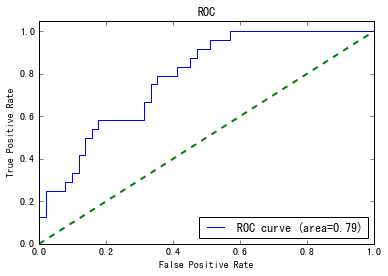

In [2]:
plt.figure()
plt.plot(fpr[2], tpr[2], label='ROC curve (area=%.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.xlim([0, 1.0])
plt.ylim([0, 1.05])
plt.legend(loc='lower right')
plt.show()

### 多分类ROC曲线

先求出micro-average、marco-average。关于marco-average、micro-average可以查看[precision/recall](https://github.com/coder-ss/ss-cheat-sheet-ml/blob/master/measurement/ROC-AUC.ipynb)那篇速查手册里面的介绍。

micro-average：

In [3]:
#micro-average
fpr['micro'], tpr['micro'], _ = roc_curve(Y_test.ravel(), Y_score.ravel())
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

macro-average：

训练样本有三个类别，每个类别样本数量不符，不能对fpr、tpr的结果直接求均值。因此demo中先统计出所有的fpr（all_fpr），然后再根据每个类别的fpr、tpr来插值得到与all_fpr维度相同的tpr，再对tpr求均值。

In [4]:
from numpy import interp

# 统计出所有的fpr
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# 根据每个类别的fpr-tpr关系将all_fpr映射为该类别的all_tpr
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    all_tpr = interp(all_fpr, fpr[i], tpr[i])
    mean_tpr += all_tpr

# 求平均，得到macro-tpr
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

ROC曲线绘制

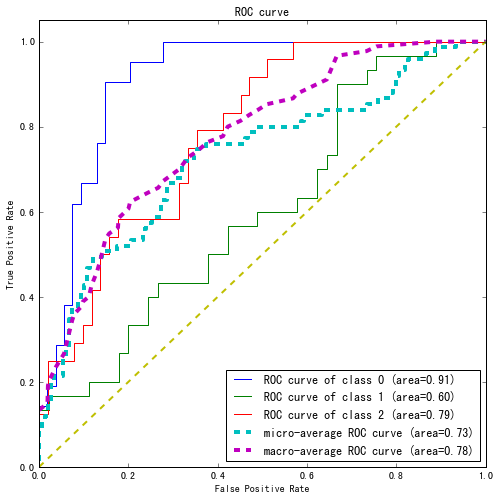

In [6]:
plt.figure(figsize=(8, 8))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class %s (area=%.2f)' % (i, roc_auc[i]))
plt.plot(fpr['micro'], tpr['micro'], label='micro-average ROC curve (area=%.2f)' % roc_auc['micro'], lw=4, linestyle='--')
plt.plot(fpr['macro'], tpr['macro'], label='macro-average ROC curve (area=%.2f)' % roc_auc['macro'], lw=4, linestyle='--')
plt.plot([0, 1], [0, 1], lw=2, linestyle='--')

plt.xlabel('False Positive Rate')    
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.xlim([0, 1.0])
plt.ylim([0, 1.05])
plt.legend(loc="lower right")
plt.show()